In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# 의사결정나무

In [125]:
# 데이터 불러오기
df_raw=pd.read_csv("Concrete.csv", engine="python")
df_raw.describe()

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [126]:
# 목표변수, 설명변수 데이터 지정
df_raw_y=df_raw["CONCRETE_COMPRESSIVE_STRENGTH"]
df_raw_x=df_raw.drop("CONCRETE_COMPRESSIVE_STRENGTH", axis=1, inplace=False)

#train_test_split(x: 설명변수 데이터, y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y=train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))


train data X size : (721, 8)
train data Y size : (721,)
test data X size : (309, 8)
test data Y size : (309,)


In [127]:
# train은 0.4, train의 validation은 0.3이 되도록 train_data를 다시 분할
df_train_x, df_val_x, df_train_y, df_val_y=train_test_split(df_train_x, df_train_y, test_size=3/7)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("validation data X size : {}".format(df_train_x_val.shape))
print("validation data Y size : {}".format(df_train_y_val.shape))


train data X size : (412, 8)
train data Y size : (412,)
validation data X size : (309, 8)
validation data Y size : (309,)


In [128]:
# 모델 생성. 기본 옵션. 모델 설명력은 train 100%, test 29.5%로 모델은 train 데이터에 과대적합
tree_uncustomized=DecisionTreeRegressor(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)
print("Score on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
print("Score on validation set: {:.3f}".format(tree_uncustomized.score(df_val_x, df_val_y)))

Score on training set: 0.999
Score on validation set: 0.743


In [129]:
# 모델 파라미터 조정: min_samples_leaf 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능
# train 및 test 설명력 결과 저장
train_score=[]
validation_score=[]

# 잎사귀 최소 자료 수
para_leaf=[n_leaf*1 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    tree=DecisionTreeRegressor(random_state=1234, min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    validation_score.append(tree.score(df_val_x, df_val_y))

# 결과 저장    
df_score_leaf=pd.DataFrame()
df_score_leaf["MinSamplesLeaf"]=para_leaf
df_score_leaf["TrainScore"]=train_score
df_score_leaf["ValidationScore"]=validation_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,ValidationScore
0,1,0.999,0.743
1,2,0.969,0.757
2,3,0.947,0.756
3,4,0.930,0.762
4,5,0.915,0.750
5,6,0.897,0.714
6,7,0.880,0.720
7,8,0.869,0.714
8,9,0.860,0.705
9,10,0.847,0.695


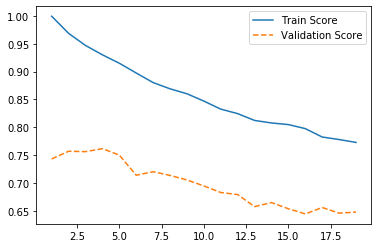

In [130]:
# 모델 설명력 그래프 확인=> 노드의 최소 자료 수를 7로 설정
plt.plot(para_leaf, train_score, linestyle="-", label="Train Score")
plt.plot(para_leaf, validation_score, linestyle="--", label="Validation Score")
plt.legend()

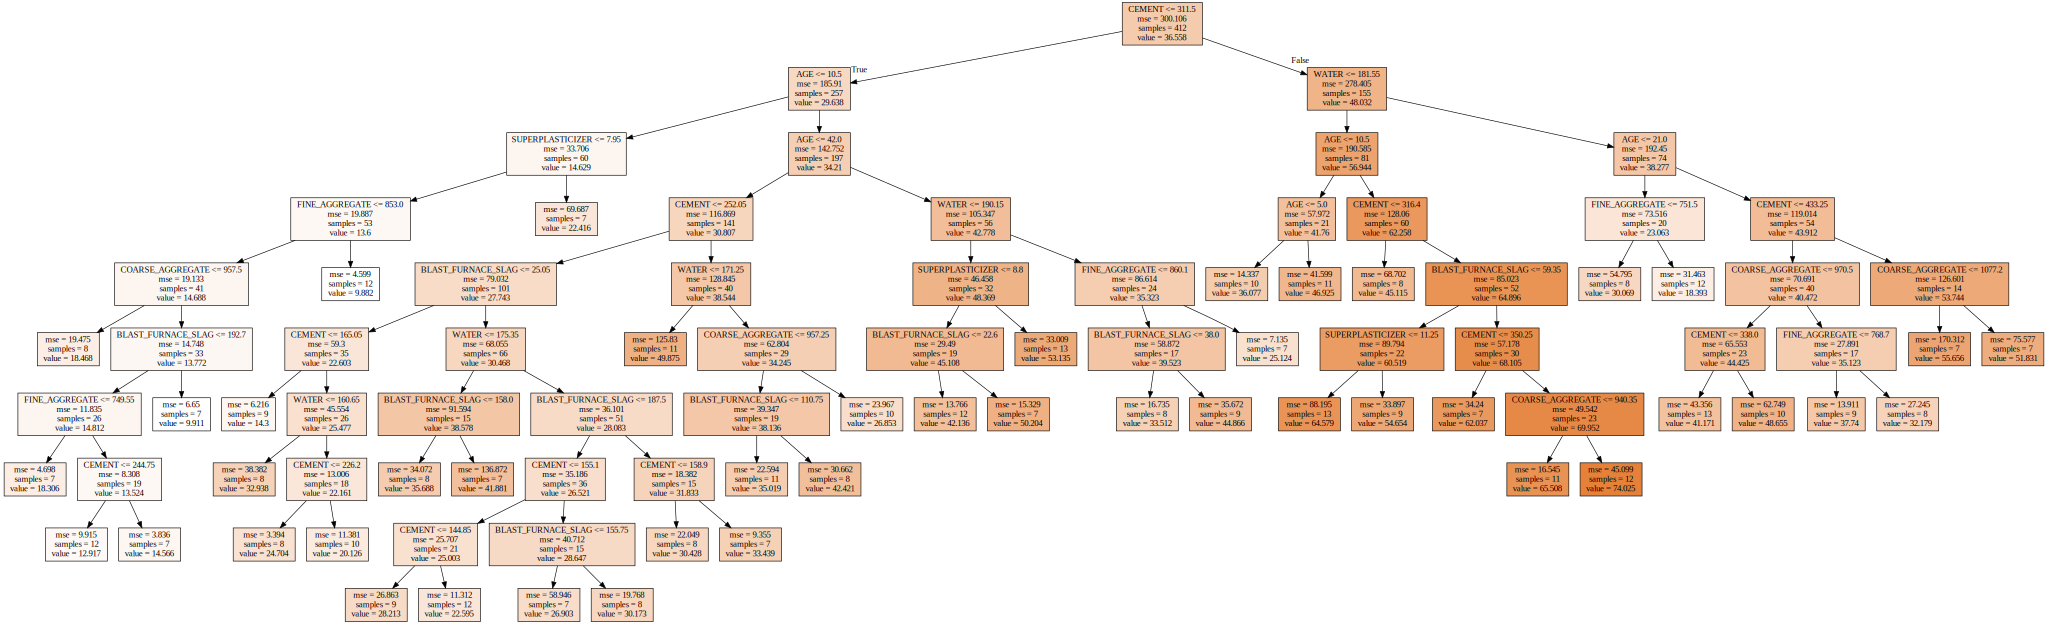

In [131]:
# 모델 파라미터 조정

#변수명 저장
v_feature_name=df_train_x.columns

#노드의 최소 자료 수=7 모델
tree_graph=DecisionTreeRegressor(random_state=1234, min_samples_leaf=7)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_leaf.dot", feature_names=v_feature_name, impurity=True, filled=True)
with open("tree_leaf.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [132]:
# 모델 파라미터 조정
# min_samples_split: 분리 노드의 최소 자료 수 변경에 따른 모델 성능

# train 및 test 설명력 결과 저장
train_score=[]
validation_score=[]

# min_samples_split: 분리 노드의 최소 자료 수
para_split=[n_split*2 for n_split in range(2,20)]

for v_min_samples_split in para_split:
    tree=DecisionTreeRegressor(random_state=1234, min_samples_leaf=7, min_samples_split=v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    validation_score.append(tree.score(df_val_x, df_val_y))

# 결과 저장    
df_score_split=pd.DataFrame()
df_score_split["MinSamplesSplit"]=para_split
df_score_split["TrainScore"]=train_score
df_score_split["ValidationScore"]=validation_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,ValidationScore
0,4,0.880,0.720
1,6,0.880,0.720
2,8,0.880,0.720
3,10,0.880,0.720
4,12,0.880,0.720
5,14,0.880,0.720
6,16,0.878,0.720
7,18,0.873,0.719
8,20,0.867,0.703
9,22,0.856,0.680


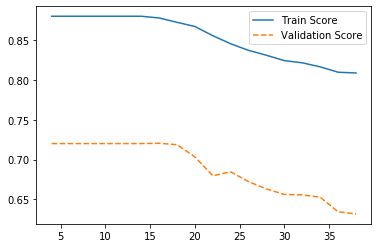

In [133]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle="-", label="Train Score")
plt.plot(para_split, validation_score, linestyle="--", label="Validation Score")
plt.legend()

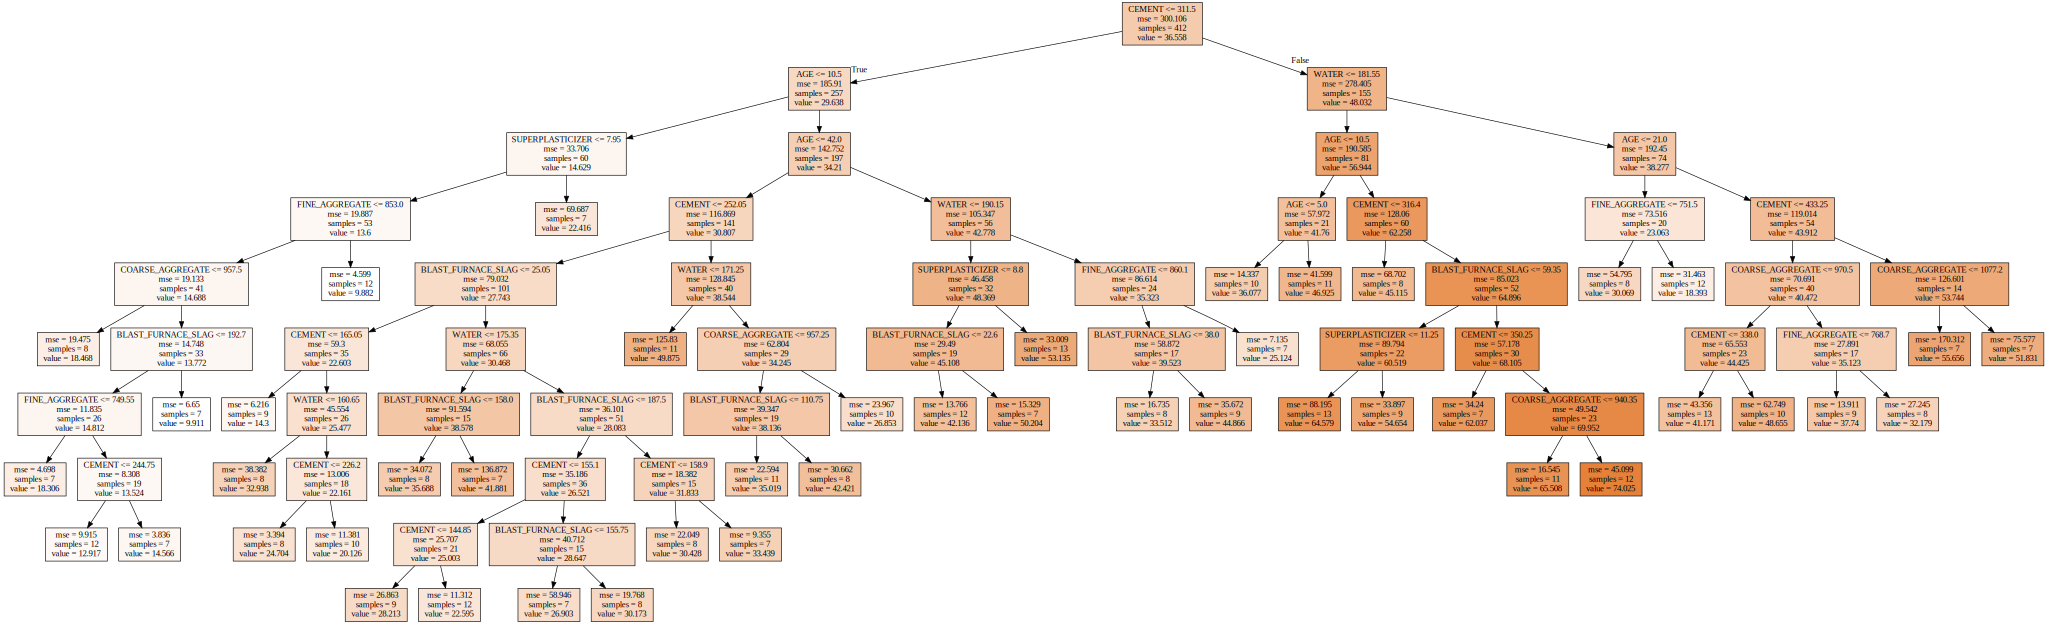

In [134]:
# 모델 파라미터 조정

# 분리 노드의 최소 자료 수=14모델 선택(validation score 기준)
tree_graph=DecisionTreeRegressor(random_state=1234, min_samples_leaf=7, min_samples_split=14)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_split.dot", feature_names=v_feature_name, impurity=True, filled=True)
with open("tree_split.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [135]:
# 모델 파라미터 조정
# train 및 test 설명력 결과 저장
train_score=[]
validation_score=[]

# max_depth: 최대 깊이 변경에 따른 모델 성능
para_depth=[depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree=DecisionTreeRegressor(random_state=1234, min_samples_leaf=7, min_samples_split=14, max_depth=v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    validation_score.append(tree.score(df_val_x, df_val_y))

# 결과 저장    
df_score_split=pd.DataFrame()
df_score_split["Depth"]=para_depth
df_score_split["TrainScore"]=train_score
df_score_split["ValidationScore"]=validation_score
df_score_split.round(3)

,Depth,TrainScore,ValidationScore
0,1,0.265,0.105
1,2,0.516,0.324
2,3,0.671,0.572
3,4,0.765,0.628
4,5,0.819,0.676
5,6,0.861,0.694
6,7,0.877,0.714
7,8,0.879,0.721
8,9,0.880,0.720
9,10,0.880,0.720


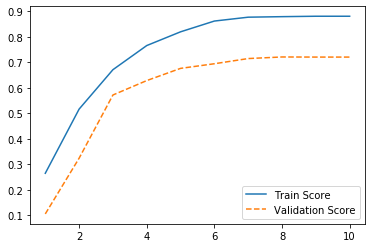

In [136]:
# 모델 설명력 그래프 확인 => 10 선택(validation score 기준)
plt.plot(para_depth, train_score, linestyle="-", label="Train Score")
plt.plot(para_depth, validation_score, linestyle="--", label="Validation Score")
plt.legend()

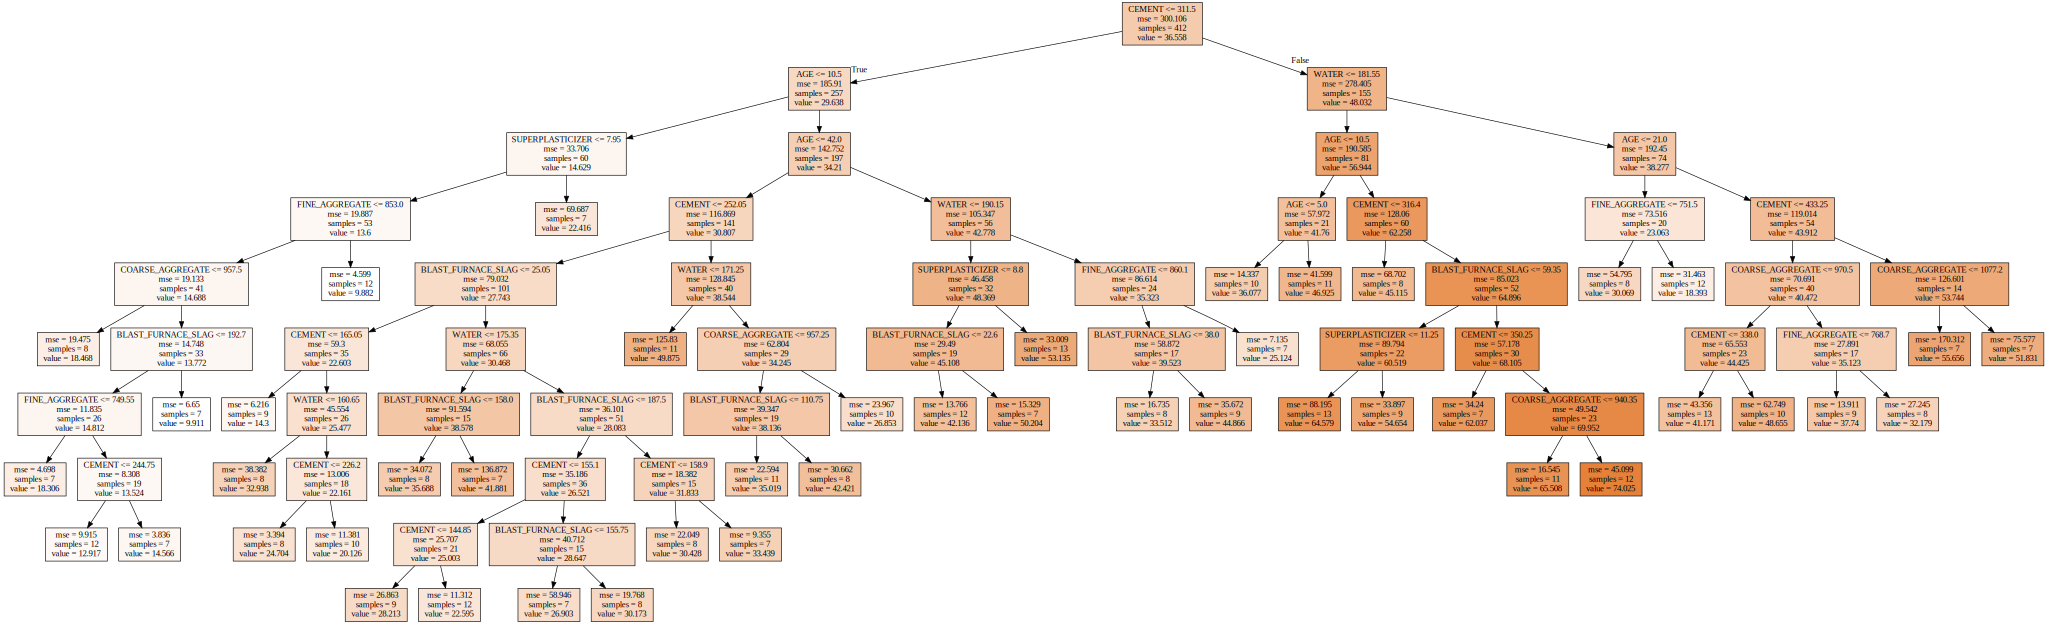

In [137]:
# 모델 파라미터 조정
# 최대 깊이 변경에 따른 모델 성능

# 최대 깊이=2모델 선택(validation score 기준)
tree_graph=DecisionTreeRegressor(random_state=1234, min_samples_leaf=7, min_samples_split=14, max_depth=10)
tree_graph.fit(df_train_x, df_train_y)

export_graphviz(tree_graph, out_file="tree_depth.dot", feature_names=v_feature_name, impurity=True, filled=True)
with open("tree_depth.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [138]:
# 최종 모델 선정
tree_final=DecisionTreeRegressor(min_samples_leaf=7, min_samples_split=14, max_depth=10, random_state=1234)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=7,
                      min_samples_split=14, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1234, splitter='best')

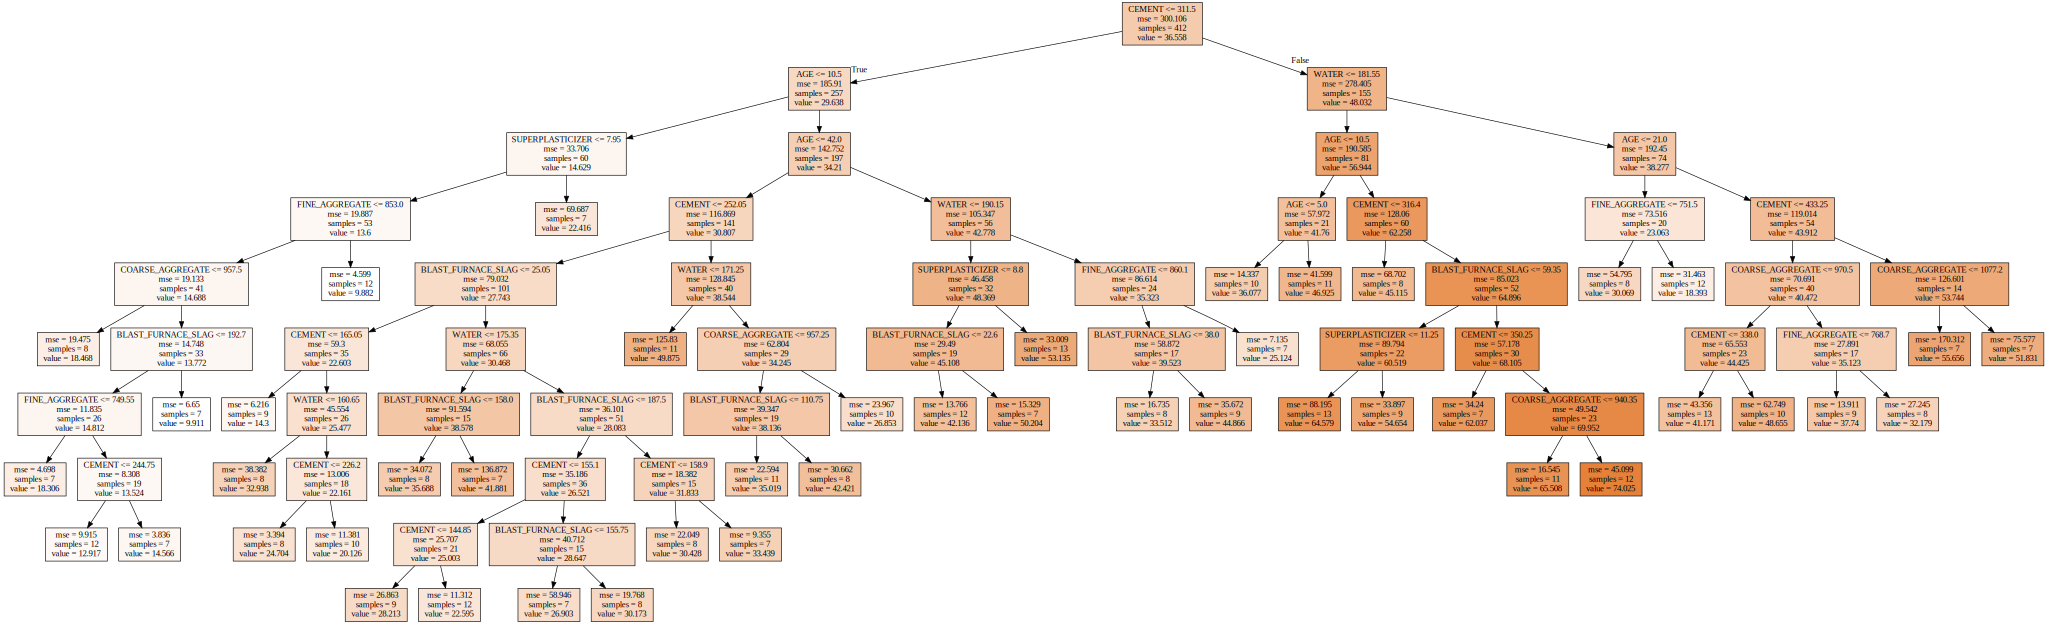

In [139]:
# 최종 모델 시각화
export_graphviz(tree_final, out_file="tree_final.dot", feature_names=v_feature_name, impurity=True, filled=True)

with open("tree_final.dot") as f:
    dot_graph=f.read()

display(graphviz.Source(dot_graph))

In [140]:
# predict method를 이용하여 예측값 구하기
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error
result=tree_final.predict(df_test_x)


# 모델의 mse
print("MSE: {}".format(mse(df_test_y, result)))
# 모델의 mae
print("MAE: {}".format(mean_absolute_error(df_test_y, result)))

MSE: 67.71199650352015
MAE: 6.471892682919382


In [141]:
# train 데이터 설명력
print("Score on training set: {:.3f}".format(tree_final.score(df_train_x, df_train_y)))
# test 데이터 설명력
print("Score on test set: {:.3f}".format(tree_final.score(df_test_x, df_test_y)))      

Score on training set: 0.880
Score on test set: 0.740


# 랜덤 포레스트

In [142]:
from sklearn.ensemble import RandomForestRegressor

In [143]:
# 데이터 불러오기
df_raw=pd.read_csv("Concrete.csv", engine="python")
df_raw.describe()

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [144]:
# 목표변수, 설명변수 데이터 지정
df_raw_y=df_raw["CONCRETE_COMPRESSIVE_STRENGTH"]
df_raw_x=df_raw.drop("CONCRETE_COMPRESSIVE_STRENGTH", axis=1, inplace=False)

#train_test_split(x: 설명변수 데이터, y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y=train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))


train data X size : (721, 8)
train data Y size : (721,)
test data X size : (309, 8)
test data Y size : (309,)


In [145]:
# 기본옵션으로 랜덤포레스트 모델 생성
rf_uncustomized=RandomForestRegressor(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

# train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 설명력
print("Score on validation set: {:.3f}".format(rf_uncustomized.score(df_val_x, df_val_y)))

Score on training set: 0.974
Score on validation set: 0.971


/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [146]:
# 모델 파라미터 조정
# n_estimators: 트리 수 변경에 따른 모델 성능

# train 및 test 설명력 결과 저장
train_score=[]
validation_score=[]

# n_estimators: 트리 수 변경: 1 ~ 100
para_n_tree=[n_tree*10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf=RandomForestRegressor(n_estimators=v_n_estimators, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    validation_score.append(rf.score(df_val_x, df_val_y))
    
# 결과 저장
df_score_n=pd.DataFrame()
df_score_n["n_estimators"]=para_n_tree
df_score_n["TrainScore"]=train_score
df_score_n["ValidationScore"]=validation_score

# 모델 설명력 확인
df_score_n.round(3)

,n_estimators,TrainScore,ValidationScore
0,10,0.974,0.971
1,20,0.979,0.977
2,30,0.981,0.979
3,40,0.982,0.979
4,50,0.982,0.979
5,60,0.983,0.980
6,70,0.983,0.980
7,80,0.983,0.979
8,90,0.983,0.979
9,100,0.983,0.979


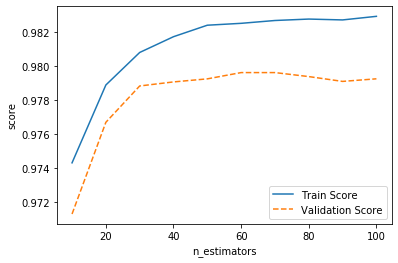

In [147]:
# 모델 설명력 그래프 확인=> 트리 수 40 모델 선택 (validation score 기준)
plt.plot(para_n_tree, train_score, linestyle="-", label="Train Score")
plt.plot(para_n_tree, validation_score, linestyle="--", label="Validation Score")
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.legend()

In [148]:
# 모델 파라미터 조정
# min_samples_leaf 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능
# train 및 test 설명력 결과 저장
train_score=[]
validation_score=[]

# min_samples_split: 분리 노드의 최소 자료 수
para_split=[n_leaf*1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf=RandomForestRegressor(random_state=1234, n_estimators=40, min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    validation_score.append(rf.score(df_val_x, df_val_y))

# 결과 저장    
df_score_leaf=pd.DataFrame()
df_score_leaf["MinSamplesSplit"]=para_leaf
df_score_leaf["TrainScore"]=train_score
df_score_leaf["ValidationScore"]=validation_score
df_score_leaf.round(3)

,MinSamplesSplit,TrainScore,ValidationScore
0,1,0.982,0.979
1,2,0.969,0.964
2,3,0.957,0.949
3,4,0.945,0.935
4,5,0.934,0.923
5,6,0.924,0.912
6,7,0.917,0.904
7,8,0.909,0.895
8,9,0.901,0.887
9,10,0.895,0.880


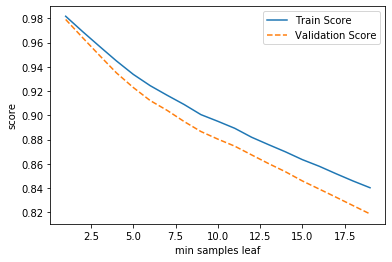

In [149]:
# 모델 설명력 그래프 확인 => 2 선택 (validation score 기준)
plt.plot(para_leaf, train_score, linestyle="-", label="Train Score")
plt.plot(para_leaf, validation_score, linestyle="--", label="Validation Score")
plt.ylabel("score")
plt.xlabel("min samples leaf")
plt.legend()

In [150]:
# 모델 파라미터 조정
# min_samples_split: 분리 노드의 최소 자료 수 변경에 따른 모델 성능

# train 및 test 설명력 결과 저장
train_score=[]
validation_score=[]

# min_samples_split: 분리 노드의 최소 자료 수
para_split=[n_split*2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf=RandomForestRegressor(random_state=1234, n_estimators=40, min_samples_leaf=2, min_samples_split=v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    validation_score.append(rf.score(df_val_x, df_val_y))

# 결과 저장    
df_score_split=pd.DataFrame()
df_score_split["MinSamplesSplit"]=para_split
df_score_split["TrainScore"]=train_score
df_score_split["ValidationScore"]=validation_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,ValidationScore
0,4,0.969,0.964
1,6,0.963,0.957
2,8,0.957,0.950
3,10,0.950,0.942
4,12,0.943,0.933
5,14,0.936,0.925
6,16,0.930,0.919
7,18,0.923,0.911
8,20,0.918,0.904
9,22,0.912,0.898


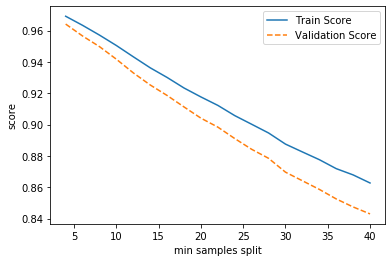

In [151]:
# 모델 설명력 그래프 확인 => 4 선택 (validation score 기준)
plt.plot(para_split, train_score, linestyle="-", label="Train Score")
plt.plot(para_split, validation_score, linestyle="--", label="Validation Score")
plt.ylabel("score")
plt.xlabel("min samples split")
plt.legend()

In [152]:
# 모델 파라미터 조정
# max_depth: 최대 깊이 변경에 따른 모델 성능

# train 및 test 설명력 결과 저장
train_score=[]
validation_score=[]

# max_depth: 최대 깊이 변경
para_depth=[depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf=RandomForestRegressor(random_state=1234, n_estimators=40, min_samples_leaf=2, min_samples_split=4, max_depth=v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    validation_score.append(rf.score(df_val_x, df_val_y))

# 결과 저장    
df_score_split=pd.DataFrame()
df_score_split["Depth"]=para_depth
df_score_split["TrainScore"]=train_score
df_score_split["ValidationScore"]=validation_score
df_score_split.round(3)

,Depth,TrainScore,ValidationScore
0,1,0.364,0.346
1,2,0.619,0.585
2,3,0.741,0.704
3,4,0.826,0.801
4,5,0.887,0.868
5,6,0.922,0.907
6,7,0.942,0.931
7,8,0.955,0.946
8,9,0.963,0.956
9,10,0.966,0.961


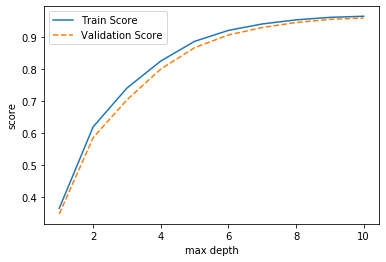

In [153]:
# 모델 파라미터 조정
# max_depth 최대 깊이 변경에 따른 모델 성능 => 5 선택 (validation score 기준)
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle="-", label="Train Score")
plt.plot(para_depth, validation_score, linestyle="--", label="Validation Score")
plt.ylabel("score")
plt.xlabel("max depth")
plt.legend()

In [154]:
# predict method를 이용하여 예측값 구하기
rf_final=RandomForestRegressor(random_state=1234, n_estimators=40, min_samples_leaf=2, min_samples_split=4, max_depth=5)
rf_final.fit(df_train_x, df_train_y)
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error
result=rf_final.predict(df_test_x)


# 모델의 mse
print("MSE: {}".format(mse(df_test_y, result)))
# 모델의 mae
print("MAE: {}".format(mean_absolute_error(df_test_y, result)))

MSE: 39.07717067147836
MAE: 5.080613454402157


In [155]:
# train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
# test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_final.score(df_test_x, df_test_y)))      

Score on training set: 0.887
Score on test set: 0.850
